In [25]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import make_pipeline  as imb_make_pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import classification_report, f1_score, auc, accuracy_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve

from prettytable import PrettyTable
from collections import Counter

%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

random_state = 42

In [2]:
df = pd.read_csv('../data/default-of-credit-card-clients.csv')
df = df.rename(columns={"PAY_0": "PAY_1"}, errors="raise")
df.drop(columns=['ID'],inplace=True)

## Feature Engineering

In [5]:
round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)

# get the first seven rows

default payment next month    1.00
PAY_1                         0.32
PAY_2                         0.26
PAY_3                         0.24
PAY_4                         0.22
PAY_5                         0.20
PAY_6                         0.19
LIMIT_BAL                     0.15
PAY_AMT1                      0.07
PAY_AMT2                      0.06
PAY_AMT3                      0.06
PAY_AMT4                      0.06
PAY_AMT5                      0.06
PAY_AMT6                      0.05
SEX                           0.04
EDUCATION                     0.03
MARRIAGE                      0.02
BILL_AMT1                     0.02
AGE                           0.01
BILL_AMT3                     0.01
BILL_AMT4                     0.01
BILL_AMT5                     0.01
BILL_AMT6                     0.01
BILL_AMT2                     0.01
Name: default payment next month, dtype: float64

## Utils

In [31]:
def drop_correlated_data(df):    
    # remove the values that have a lower correlation in absolute value
    low_corr_cols = pd.Series(round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)[8:].index)
    df = df.drop(columns=low_corr_cols)
    
    y, X = df["default payment next month"], df.drop("default payment next month", axis=1)
    
    return X,y

def split_data(X,y, random_state=42):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                        stratify= y, random_state=random_state)

    return X_train, X_test, y_train, y_test

def report(y_true, y_pred, title = "", 
           params = None, show_cm = True, show_params = True):

    nl = '\n'
    sp = "*"*len(title)
    
#     print("__"*30 + nl)
    if title:
        title = "Classification report for " + title + " on yet-unseen data"
        sp = "*"*len(title)
        print(sp + nl + title + nl + sp +nl)
    
    acc = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    print("Accuracy: {:.3f}".format(acc))
    print("f-score: {:.3f}".format(f_score))
    
    if params and show_params:
        new_params = {}
        for k in params:
            new_params[k.split("__")[-1]] = params[k]
            
        print("\nBest Parameters:")
#         pprint(new_params, indent = 4)
        print(grid_search.best_estimator_)
        
#     print(classification_report(y_true, y_pred))
    if show_cm:
        plt.figure(figsize = (6,5))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot = True, 
                    cmap = 'YlGnBu', 
                    annot_kws={"size": 18},
                    linecolor = 'w',
                    linewidth = 4
                   )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
    
    return (acc, f_score)
    
scores_dict = {}
gs_trained_models =  {}

def outliers_iqr(df):
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1
    
    df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    y = df_out["default payment next month"]
    X = df_out.drop(columns=["default payment next month"])
    
    return X, y

def outliers_lof(df, n_neighbors=20):
    
    y, X = df["default payment next month"], df.drop("default payment next month", axis=1)
    
    y = np.asarray(y)
    X = np.asarray(X)

    outliers = LocalOutlierFactor(n_neighbors = n_neighbors, n_jobs = -1).fit_predict(X)
    X = X[outliers == 1, :]
    y = y[outliers == 1]

    return X, y

In [70]:
random_state = 42

scaler = StandardScaler()

pca = PCA(n_components=11, random_state=random_state)

under_s = RandomUnderSampler(sampling_strategy=0.8, random_state=random_state)
over_s = SMOTE(sampling_strategy=0.5, random_state=random_state)
smoteenn = SMOTEENN(random_state=random_state)

cases = []

params = {
    "randomforestclassifier" : {
        "randomforestclassifier__n_estimators":[80,100,120],
        "randomforestclassifier__criterion":["gini", "entropy"],
        "randomforestclassifier__max_depth":[8,10,12],
        "randomforestclassifier__min_samples_split":[2,4,6],
        "randomforestclassifier__max_features":['sqrt','log2'],
    },
    "svc" : {
        "svc__kernel": ['linear', 'rbf', 'poly'],
        "svc__gamma" :['scale', 'auto'],
        "svc__tol": [1e-2,1e-3,1e-4],
        "svc__C": [0.5,0.8, 1.0,1.2, 1.5] 
    },
    "knn" : {
        "knn_n" : [3,5,7,9]
    }
}

models = {
    "randomforestclassifier" : RandomForestClassifier(random_state=random_state),
    "knn" : KNeighborsClassifier(n_neighbors=9),
    "svm" : SVC(),
} 

In [48]:
def perform_all_tests(df, features_filtering, pca_options, outliers_options, resampling_options, model_name, models, random_state):
    
    y, X = df["default payment next month"], df.drop("default payment next month", axis=1)

    table = PrettyTable()

    table.title = f'Results for {model_name}'
    table.field_names = ['Preprocessing','Accuracy','F1']

    for ff in features_filtering:
        for pca_opt in pca_options:
            for outliers_opt in outliers_options:
                for resampling_opt in resampling_options:

                    field_0 = ''

                    if ff:
                        field_0 += 'Drop corr + '
                        X, y = drop_correlated_data(df)


                    if outliers_opt:

                        if outliers_opt == "iqr":
                            X, y = outliers_iqr(df)
                            field_0 += 'IQR + '

                        if outliers_opt == "lof":
                            X, y = outliers_lof(df)
                            field_0 += 'LOF + '
                    
                    # if ff = True, 
                    # this combination should be avoided
                    if ff:
                        continue

                    # both imb_make_pipeline and make_pipeline have some problems 
                    # with giving an array as input. So I manually check for each combinations
                    if pca_opt and resampling_opt:
                        field_0 += f'Scaling + PCA + {str(resampling_opt).split("(")[0]}'
                        pipeline = imb_make_pipeline(scaler,pca,resampling_opt,models[model_name])

                    elif not pca_opt and resampling_opt:
                        field_0 += f'Scaling + {str(resampling_opt).split("(")[0]}'
                        pipeline = imb_make_pipeline(scaler,resampling_opt,models[model_name])

                    elif pca_opt and not resampling_opt:
                        field_0 += f'Scaling + PCA'
                        pipeline = make_pipeline(scaler,pca,models[model_name])

                    elif not pca_opt and not resampling_opt:
                        field_0 += f'Scaling'
                        pipeline = make_pipeline(scaler,models[model_name])

                    X_train, X_test, y_train, y_test = split_data(X, y, 42)

                    pipeline.fit(X_train, y_train)
                    y_predicted = pipeline.predict(X_test)

                    accuracy = accuracy_score(y_test,y_predicted)
                    f1 = f1_score(y_test,y_predicted)

                    table.add_row([field_0, round(accuracy,4), round(f1,4)])   
                    
    print(table)

# Random Forest

In [49]:
features_filtering = [True,False]
pca_options = [False, pca]
outliers_options = [None, "lof"]
resampling_options = [None, under_s, over_s, smoteenn]

perform_all_tests(df,features_filtering,pca_options, outliers_options,resampling_options,"randomforestclassifier",models,random_state)

# best f1 
# | Drop corr + LOF + Scaling + RandomUnderSampler |  0.7776  | 0.5491 |
# | Drop corr + LOF + Scaling + RandomUnderSampler |  0.7776  | 0.5491 |
# |          Scaling + RandomUnderSampler          |  0.7776  | 0.5491 |
# |       LOF + Scaling + RandomUnderSampler       |  0.7776  | 0.5491 |

+--------------------------------------------------------------------+
|                     Results for f{model_name}                      |
+------------------------------------------------+----------+--------+
|                 Preprocessing                  | Accuracy |   F1   |
+------------------------------------------------+----------+--------+
|              Drop corr + Scaling               |  0.7975  | 0.4438 |
|    Drop corr + Scaling + RandomUnderSampler    |  0.7343  | 0.4811 |
|          Drop corr + Scaling + SMOTE           |  0.7884  | 0.4582 |
|         Drop corr + Scaling + SMOTEENN         |  0.7371  | 0.4933 |
|           Drop corr + LOF + Scaling            |  0.8162  | 0.4896 |
| Drop corr + LOF + Scaling + RandomUnderSampler |  0.7776  | 0.5491 |
|       Drop corr + LOF + Scaling + SMOTE        |  0.8163  | 0.5237 |
|      Drop corr + LOF + Scaling + SMOTEENN      |  0.7635  | 0.5484 |
|              Drop corr + Scaling               |  0.7975  | 0.4438 |
|    D

In [82]:
# CROSS VALIDATE THE HYPERPARAMS ON THE BEST PREPROCESSING PIPELINE

pipeline = make_pipeline(StandardScaler(), models["randomforestclassifier"])

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=random_state)

grid_search = GridSearchCV(pipeline, params["randomforestclassifier"],
                               scoring = 'f1',
                               n_jobs=-1,
                               cv=stratified_kfold,
                    )
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
grid_search.best_estimator_

Wall time: 0 ns


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='sqrt',
                                        min_samples_split=4,
                                        random_state=42))])

*******************************************************************
Classification report for RandomForestClassifier on yet-unseen data
*******************************************************************

Accuracy: 0.818
f-score: 0.467

Best Parameters:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='sqrt',
                                        min_samples_split=4,
                                        random_state=42))])


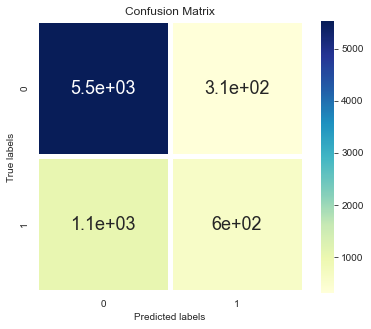

In [83]:
acc, fscore = report(y_test, y_pred, "RandomForestClassifier", grid_search.best_params_, True, True)
scores_dict["RandomForestClassifier"] = fscore

# KNN

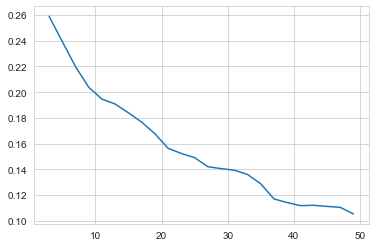

In [65]:
# choose the value of K

k_list = [i for i in range(3,50,2)]
f1_list = []

y, X = df["default payment next month"], df.drop("default payment next month", axis=1)
X_train, X_test, y_train, y_test = split_data(X, y, 42)

for k in k_list:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    f1_list.append(f1_score(y_test,y_pred))
    

plt.plot(k_list,f1_list)    

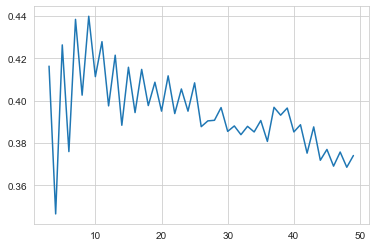

In [64]:
# choose the value of K

k_list = [i for i in range(3,50)]
f1_list = []

X_filt, y_filt = drop_correlated_data(df)
X_train, X_test, y_train, y_test = split_data(X_filt, y_filt, 42)

for k in k_list:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    f1_list.append(f1_score(y_test,y_pred))
    

plt.plot(k_list,f1_list)    

In [71]:
features_filtering = [True,False]
pca_options = [False, pca]
outliers_options = [None, "lof"]
resampling_options = [None, under_s, over_s, smoteenn]

perform_all_tests(df,features_filtering,pca_options, outliers_options,resampling_options,"knn",models,random_state)

+--------------------------------------------------------------------+
|                     Results for f{model_name}                      |
+------------------------------------------------+----------+--------+
|                 Preprocessing                  | Accuracy |   F1   |
+------------------------------------------------+----------+--------+
|              Drop corr + Scaling               |  0.8056  | 0.4502 |
|    Drop corr + Scaling + RandomUnderSampler    |  0.7577  | 0.4951 |
|          Drop corr + Scaling + SMOTE           |  0.7937  | 0.4976 |
|         Drop corr + Scaling + SMOTEENN         |  0.7491  | 0.5034 |
|           Drop corr + LOF + Scaling            |  0.8064  | 0.4562 |
| Drop corr + LOF + Scaling + RandomUnderSampler |  0.749   | 0.5119 |
|       Drop corr + LOF + Scaling + SMOTE        |  0.773   | 0.5039 |
|      Drop corr + LOF + Scaling + SMOTEENN      |  0.6252  | 0.4749 |
|              Drop corr + Scaling               |  0.8056  | 0.4502 |
|    D